# Do British tabloids treat Meghan Markle more negatively than Kate Middleton?

For my final project, I applied natural language processing techniques to investigate whether Meghan Markle has been treated more negatively by British tabloids than Kate Middleton.

To do this, I examined articles mentioning Markle and Middleton in key tabloids over the last two years. I looked at both the different words and topics associated with each woman. While sentiment analysis seemed like an obvious choice, I did not use this technique because it is unreliable, especially when applied to complex sentences with multiple subjects.


## Methodology

**Timeframe**
<br>
I chose to collect articles published over the last two years from Nov. 27, 2017 to Nov. 27, 2019. While I originally wanted to compare the two-year period centered around each royal marriage, The Sun and The Mirror do not allow users to search for articles published earlier than around 2016. Unfortunately, Middleton's marriage was over seven years ago on April 29, 2011. Regardless, the two-year period ensured an adequate sample size of articles.

**Choosing news outlets**
<br>
There are no news APIs or ready-made datasets of British tabloid articles, so I made my own. I used web scraping to collect articles about Middleton and Markle over a two-year period from Britain's top three tabloids by circulation:


**The Sun**
- A tabloid newspaper founded in 1964 and published in the United Kingdom and Ireland.
- thesun.co.uk
- circulation: 1,240,959


**Daily Mail**
- A daily middle-market tabloid newspaper published in London.
- dailymail.co.uk
- circulation: 1,166,500

**The Mirror**
- A national daily tabloid newspaper founded in 1903.
- mirror.co.uk
- circulation: 463,256 (daily)

**Collecting articles**
<br>
To collect the articles, I used each tabloid website's search feature to search "Kate Middleton" and "Meghan Markle." I scraped the search results and then filtered them to include only articles that contain "Kate" and/or "Middleton" and "Meghan" and/or "Markle" in their headlines. I also filtered the articles based on my two-year timeframe of interest.

This resulted in the following number of articles:
<br>
- **Middleton:** 2,348
<br>
- **Markle:** 8,530


## Analysis

### Combining my dataframes

I have six dataframes: Two per outlet for both Meghan and Kate. I'm going to combine them into two big dataframes. One with all of the articles about Kate and one with all of the articles about Meghan.

In [19]:
import glob
import nltk
from string import punctuation
import pandas as pd
from nltk.corpus import stopwords
from nltk import bigrams
from nltk import BigramCollocationFinder
from nltk import TrigramCollocationFinder

In [9]:
middleton_DM_df = pd.read_csv('middleton_dm_stories_Nov17to19.csv', usecols=['article','title','link','author','date'])


In [10]:
markle_DM_df = pd.read_csv('markle_DM_stories_Nov17to19.csv', usecols=['article','title','link','author','date'])


In [11]:
middleton_sun_df = pd.read_csv('middleton_sun_stories_Nov17to19.csv', usecols=['article','title','link','author','date'])                          


In [12]:
markle_sun_df = pd.read_csv('markle_sun_stories_Nov17to19.csv', usecols=['article','title','link','author','date'])


In [13]:
middleton_mirror_df = pd.read_csv('middleton_mirror_stories_Nov17to19.csv', usecols=['article','title','link','author','date'])


In [14]:
markle_mirror_df = pd.read_csv('markle_mirror_stories_Nov17to19.csv', usecols=['article','title','link','author','date'])


In [15]:
middleton_all_df = middleton_DM_df.append([middleton_sun_df, middleton_mirror_df], ignore_index=True)

/Users/amyokruk/.pyenv/versions/3.6.5/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [16]:
# Dataframe with all of the articles about Middleton
middleton_all_df.shape

(2348, 5)

In [17]:
markle_all_df = markle_DM_df.append([markle_sun_df, markle_mirror_df], ignore_index=True)

In [18]:
# Dataframe with all of the articles about Markle
markle_all_df.shape

(8530, 5)

## When it comes to U.K. tabloids, what words are associated with Kate versus Meghan?

### Bigrams 

Each article was processed to identify the bigrams in these scripts that had either words associated with Middleton or Markle as the first word in the bigram.





Let's look at our file:

In [20]:
middleton_all_df.head()

,article,author,date,link,title
0,['Kate Middleton has cheekily tweeted the eye ...,By Sarah Finley For Mailonline,2019-11-26 13:45:45,/femail/article-7727077/Kate-Middleton-reacts-...,One is amused! Kate Middleton cheekily tweets ...
1,"[""Captivating pictures have shown how the roya...",By Jessica Rach For Mailonline,2019-11-25 11:39:09,/femail/article-7722437/How-Archie-look-grows-...,The future faces of royalty: Fascinating compu...
2,"[""Meghan Markle is aware she is being 'pitted ...",By Hayley Richardson For Mailonline,2019-11-25 10:49:23,/femail/article-7722387/Meghan-Markle-aware-pi...,Meghan Markle is 'aware' she's being 'pitted a...
3,"[""Prince William and Kate Middleton's 'strippe...",By Stephanie Linning Harriet Johnston For Mail...,2019-11-22 16:24:34,/femail/article-7715019/Expert-suggests-Prince...,Modern parents Kate Middleton and Meghan Markl...
4,"[""Kate Middleton has written personal thank yo...",By Harriet Johnston For Mailonline,2019-11-22 12:30:03,/femail/article-7714195/Kate-Middleton-wrote-p...,Royally grateful! Kate Middleton sent a person...


### Pre-processing the articles

I'm going to pre-process the text to make analysis easier. This avoids having multiple copies of the same words, such as "Royal" and "royal," for example.

In [21]:
# A function to clean up the articles for text mining
def preprocess(article):
#     lower case
    article = article.apply(lambda x: " ".join(x.lower() for x in x.split()))
#     remove punctuation 
    article = article.str.replace('xa0','')
    article = article.str.replace('\n','')
    article = article.str.replace('[^\w\s]','')
    article = article.str.replace('[\d+]','')
    article = article.str.replace('[_]','')
#     remove stop words 
    stop = stopwords.words('english')
    article = article.apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    return article

In [22]:
# saving the results back into my dataframe
middleton_all_df['article'] = preprocess(middleton_all_df['article'])

### Finding words associated with Kate

In [23]:
middleton_bigrams = []

def bigrammer(text):
    # Finding bigrams that commonly co-occur in the article  
    finder = BigramCollocationFinder.from_words(text.split())
    # Creating a filter for only bigrams that include with Kate (or see variations)  
    word_filter = lambda w1, w2: "kate" not in (w1, w2) and "middleton" not in (w1, w2)
    # Applying the filter 
    finder.apply_ngram_filter(word_filter)
    # Applying the filter 
    
    # Finding most important bigrams 
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    
    # Find top 10 ngrams
    raw_freq_ranking = finder.nbest(bigram_measures.raw_freq, 10) 
    
    final_list = []
    # Filtering for only bigrams that start with Kate, etc.
    final = [final_list.append(x) for x in raw_freq_ranking if x[0] == 'kate' or x[0] == 'middleton']
    # Create a list of filtered results 
    return middleton_bigrams.append(final_list)

In [ ]:
# saving the results back into my dataframe
middleton_all_df['article'].apply(bigrammer)

In [25]:
len(middleton_bigrams)

2348

In [26]:
middleton_bigrams

[[('kate', 'chose'),
  ('kate', 'middleton'),
  ('kate', 'obviously'),
  ('kate', 'said'),
  ('kate', 'try'),
  ('middleton', 'cheekily')],
 [('kate', 'middleton'),
  ('kate', 'prince'),
  ('kate', 'resembling'),
  ('middleton', 'dyed')],
 [('kate', 'groomed'),
  ('kate', 'comments'),
  ('kate', 'middleton'),
  ('kate', 'missed'),
  ('kate', 'queen'),
  ('kate', 'reached')],
 [('kate', 'attend'),
  ('kate', 'chosen'),
  ('kate', 'felt'),
  ('kate', 'middletons'),
  ('kate', 'williams')],
 [('kate', 'chose'),
  ('kate', 'completed'),
  ('kate', 'middleton'),
  ('kate', 'mixed'),
  ('kate', 'options'),
  ('kate', 'praised'),
  ('kate', 'wowed'),
  ('kate', 'wrote')],
 [('kate', 'appeared'), ('kate', 'felt'), ('kate', 'forced'), ('kate', 'met')],
 [('middleton', 'wrapped')],
 [('kate', 'collecting'),
  ('kate', 'fashion'),
  ('kate', 'middleton'),
  ('kate', 'reached'),
  ('kate', 'whats'),
  ('middleton', 'meghan')],
 [('kate', 'holding'),
  ('kate', 'middleton'),
  ('kate', 'slingshot')

### Finding words associated with Meghan Markle 

In [27]:
# A function to clean up the articles for text mining
def preprocess(article):
#     lower case
    article = article.apply(lambda x: " ".join(x.lower() for x in x.split()))
#     remove punctuation 
    article = article.str.replace('xa0','')
    article = article.str.replace('\n','')
    article = article.str.replace('[^\w\s]','')
    article = article.str.replace('[\d+]','')
    article = article.str.replace('[_]','')
#     remove stop words 
    stop = stopwords.words('english')
    article = article.apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    return article

In [28]:
# saving the results back into my dataframe
markle_all_df['article'] = preprocess(markle_all_df['article'])

In [29]:
markle_bigrams = []

def bigrammer(text):
    # Finding bigrams that commonly co-occur in the article  
    finder = BigramCollocationFinder.from_words(text.split())
    # Creating a filter for only bigrams that include with Kate (or see variations)  
    word_filter = lambda w1, w2: "meghan" not in (w1, w2) and "markle" not in (w1, w2)
    # Applying the filter 
    finder.apply_ngram_filter(word_filter)
    # Applying the filter 
    
    # Finding most important bigrams 
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    
    # Find top 10 ngrams
    raw_freq_ranking = finder.nbest(bigram_measures.raw_freq, 10) 
    
    final_list = []
    # Filtering for only bigrams that start with Kate, etc.
    final = [final_list.append(x) for x in raw_freq_ranking if x[0] == 'meghan' or x[0] == 'markle']
    # Create a list of filtered results 
    return markle_bigrams.append(final_list)

In [42]:
markle_all_df['article'].apply(bigrammer)

In [31]:
len(markle_bigrams)

8530

In [32]:
markle_bigrams

[[('markle', 'close'),
  ('markle', 'junior'),
  ('markle', 'since'),
  ('markle', 'thomas'),
  ('markle', 'wrote')],
 [('meghan', 'markle'),
  ('markle', 'allowed'),
  ('markle', 'thanked'),
  ('meghan', 'harry'),
  ('meghan', 'one')],
 [('markle', 'aware'),
  ('meghan', 'admitted'),
  ('meghan', 'aware'),
  ('meghan', 'best')],
 [('markle', 'reportedly'),
  ('meghan', 'handson'),
  ('meghan', 'happy'),
  ('meghan', 'markle'),
  ('meghan', 'opted'),
  ('meghan', 'teamed'),
  ('meghan', 'welcomed')],
 [('markle', 'prince'), ('meghan', 'african'), ('meghan', 'opened')],
 [('markle', 'thanked'),
  ('meghan', 'get'),
  ('meghan', 'markle'),
  ('meghan', 'stepped'),
  ('meghan', 'trees')],
 [('meghan', 'championed')],
 [('markle', 'believed'),
  ('markle', 'looks'),
  ('markle', 'markle'),
  ('meghan', 'added'),
  ('meghan', 'cuddling'),
  ('meghan', 'going')],
 [('markle', 'also'),
  ('meghan', 'already'),
  ('meghan', 'issues'),
  ('meghan', 'markle')],
 [('meghan', 'get'), ('meghan', 't

In [33]:
# test2 = [y for x in markle_bigrams for y in x]


In [34]:
# test_df2 = pd.DataFrame(test2)
# test_df2.head()


In [35]:
# test_df2[1].value_counts()

# Using the bigrams to find the words that exhibit the biggest differences between relative use for Kate and Meghan.

In [36]:
# Taking all of the Middleton bigrams and turning them into a big list 
mid_bigrams_all = [y for x in middleton_bigrams for y in x]

In [37]:
# Taking all of the Markle bigrams and turning them into a big list 
mar_bigrams_all = [y for x in markle_bigrams for y in x]

In [38]:
# Combining the bigrams
bigrams_all = mid_bigrams_all + mar_bigrams_all

In [39]:
len(bigrams_all)

46550

In [40]:
# Turning the bigrams into a dataframe
bigrams = pd.DataFrame(bigrams_all)

In [43]:
bigrams.head(3)

,0,1
0,kate,chose
1,kate,middleton
2,kate,obviously


In [44]:
# Restructuring the dataframe to group by every unique word associated with either Kate or Meghan
bigram_counts = bigrams.groupby(by=1)[0].apply(', '.join).reset_index()

In [45]:
# Renaming columns
bigram_counts = bigram_counts.rename(columns={1:'words',0:'list'})

In [46]:
bigram_counts.head()

,words,list
0,abandoned,"meghan, meghan, meghan, meghan"
1,abandoning,"meghan, meghan, meghan, meghan, meghan, meghan"
2,abbie,meghan
3,abigail,"kate, meghan, meghan, meghan, meghan, meghan, ..."
4,abigailgrabbed,meghan


In [47]:
# Creating a function to take the list column and turn it into a list recognized by pandas 
def func(row):
    row = row.split(",")
    return row

In [48]:
# Applying the function
bigram_counts.list = bigram_counts.list.apply(func)

In [49]:
# Looking at the result
bigram_counts.head()

,words,list
0,abandoned,"[meghan, meghan, meghan, meghan]"
1,abandoning,"[meghan, meghan, meghan, meghan, meghan, ..."
2,abbie,[meghan]
3,abigail,"[kate, meghan, meghan, meghan, meghan, me..."
4,abigailgrabbed,[meghan]


In [50]:
# Counting how many times each word is associated with Kate and creating a new column
bigram_counts['kate'] = bigram_counts.apply(lambda row : len([m for m in row['list'] if m.strip() == "kate" or m.strip() == "middleton"]), axis=1)

In [51]:
# Counting how many times each word is associated with Meghan and creating a new column
bigram_counts['meghan'] = bigram_counts.apply(lambda row : len([m for m in row['list'] if m.strip() == "meghan" or m.strip() == "markle"]), axis=1)

In [52]:
# Looking at the new columns
bigram_counts.tail()

,words,list,kate,meghan
4819,youre,"[kate, kate, meghan, markle, meghan, mark...",2,6
4820,youve,"[markle, markle, markle, markle]",0,4
4821,zara,"[middleton, kate, kate, meghan]",3,1
4822,zimbabwean,[markle],0,1
4823,zoe,[markle],0,1


In [53]:
# Creating a column that will show how many time each word appears in any bigram
totals = bigrams[1].value_counts()
totals = totals.reset_index()
totals = totals.rename(columns={'index':'words', 1:'total'})

In [54]:
# Joiing the new totals column to our old dataframe
bigram_counts = bigram_counts.merge(totals, how='outer', on='words')
bigram_counts = bigram_counts.sort_values(by='total', ascending=False)

In [55]:
bigram_counts.head(5)

,words,list,kate,meghan,total
2697,markle,"[meghan, meghan, meghan, markle, meghan, ...",0,4659,4659
2074,harry,"[kate, kate, kate, kate, kate, kate, kat...",31,1541,1572
3369,prince,"[kate, middleton, middleton, kate, kate, ...",174,1112,1286
2726,markles,"[meghan, meghan, meghan, meghan, meghan, ...",0,1115,1115
2814,middleton,"[kate, kate, kate, kate, kate, kate, kat...",957,0,957


In [56]:
# Counting the overall number of words associated with Kate
kate_total = bigram_counts.kate.sum()

In [57]:
# Counting the overall number of words associated with Meghan
meghan_total = bigram_counts.meghan.sum()

In [58]:
# Calculating each word's relative frequency (Meghan)
bigram_counts['meghan_2'] = bigram_counts['meghan'].apply(lambda x: x / meghan_total)

In [59]:
# Calculating each word's relative frequency (Kate)
bigram_counts['kate_2'] = bigram_counts['kate'].apply(lambda x: x / kate_total)

In [60]:
# Calculating the words *most* associated with Kate versus Meghan
bigram_counts['freq'] = bigram_counts.kate_2 / bigram_counts.meghan_2

In [61]:
bigram_counts.head()

,words,list,kate,meghan,total,meghan_2,kate_2,freq
2697,markle,"[meghan, meghan, meghan, markle, meghan, ...",0,4659,4659,0.124612,0.000000,0.000000
2074,harry,"[kate, kate, kate, kate, kate, kate, kat...",31,1541,1572,0.041216,0.003384,0.082092
3369,prince,"[kate, middleton, middleton, kate, kate, ...",174,1112,1286,0.029742,0.018991,0.638538
2726,markles,"[meghan, meghan, meghan, meghan, meghan, ...",0,1115,1115,0.029822,0.000000,0.000000
2814,middleton,"[kate, kate, kate, kate, kate, kate, kat...",957,0,957,0.000000,0.104453,inf


In [62]:
# Getting rid of 0 and infinity to get rid of words (from the bigrams) that did not appear in the corpus more than once, etc.
bigram_counts2 = bigram_counts[(bigram_counts.freq != 0) & (bigram_counts.freq != float("inf"))]

### Word's most associated with Meghan

In [114]:
meghan_words = bigram_counts2.sort_values(by='freq', ascending=True).head(20)
meghan_words

,words,list,kate,meghan,total,meghan_2,kate_2,freq
2077,harrys,"[middleton, kate, meghan, meghan, meghan, ...",2,361,363,0.009656,0.000218,0.022608
127,aisle,"[kate, meghan, meghan, meghan, meghan, me...",1,145,146,0.003878,0.000109,0.028143
2159,hollywood,"[kate, meghan, meghan, meghan, meghan, ma...",1,52,53,0.001391,0.000109,0.078476
2074,harry,"[kate, kate, kate, kate, kate, kate, kat...",31,1541,1572,0.041216,0.003384,0.082092
1827,former,"[middleton, markle, meghan, markle, markle...",1,48,49,0.001284,0.000109,0.085016
2966,news,"[middleton, markle, meghan, meghan, meghan...",1,43,44,0.001150,0.000109,0.094902
4763,wont,"[kate, kate, meghan, markle, meghan, mark...",2,83,85,0.002220,0.000218,0.098332
331,away,"[kate, meghan, meghan, meghan, meghan, me...",1,41,42,0.001097,0.000109,0.099531
4404,tie,"[middleton, meghan, markle, markle, markle...",1,41,42,0.001097,0.000109,0.099531
2332,invited,"[kate, meghan, meghan, meghan, meghan, me...",1,39,40,0.001043,0.000109,0.104635


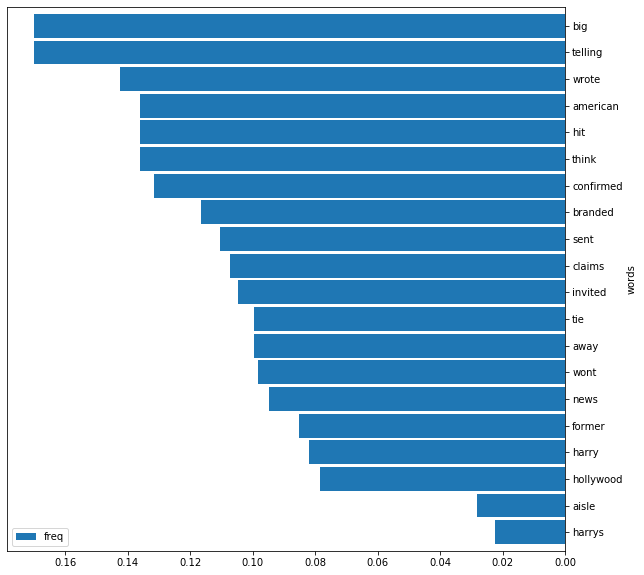

In [128]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
ax2 = meghan_words.plot.barh(x='words', y='freq', width=.9, figsize=(10,10))
ax2.invert_xaxis()
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
plt.savefig("markle_bars.pdf")

### Words most associated with Kate

In [98]:
kate_words = bigram_counts2.sort_values(by='freq', ascending=False).head(20)

In [99]:
kate_words

,words,list,kate,meghan,total,meghan_2,kate_2,freq
1089,cry,"[kate, kate, kate, kate, kate, kate, kat...",28,1,29,0.000027,0.003056,114.261515
3233,pippa,"[middleton, kate, kate, kate, kate, kate,...",51,2,53,0.000053,0.005566,104.059594
4731,william,"[kate, kate, kate, kate, kate, kate, kat...",283,13,296,0.000348,0.030888,88.835189
4735,wills,"[kate, kate, kate, kate, kate, kate, kat...",103,5,108,0.000134,0.011242,84.063829
4327,tears,"[middleton, kate, middleton, middleton, ka...",20,1,21,0.000027,0.002183,81.615368
2355,james,"[middleton, middleton, middleton, middleton...",11,1,12,0.000027,0.001201,44.888452
756,charlotte,"[kate, kate, kate, kate, kate, kate, kat...",7,1,8,0.000027,0.000764,28.565379
4636,vogue,"[kate, kate, middleton, middleton, middlet...",7,1,8,0.000027,0.000764,28.565379
186,anmer,"[kate, kate, kate, kate, kate, kate, meg...",6,1,7,0.000027,0.000655,24.484610
4230,suffering,"[kate, kate, kate, kate, kate, kate, kat...",10,2,12,0.000053,0.001091,20.403842


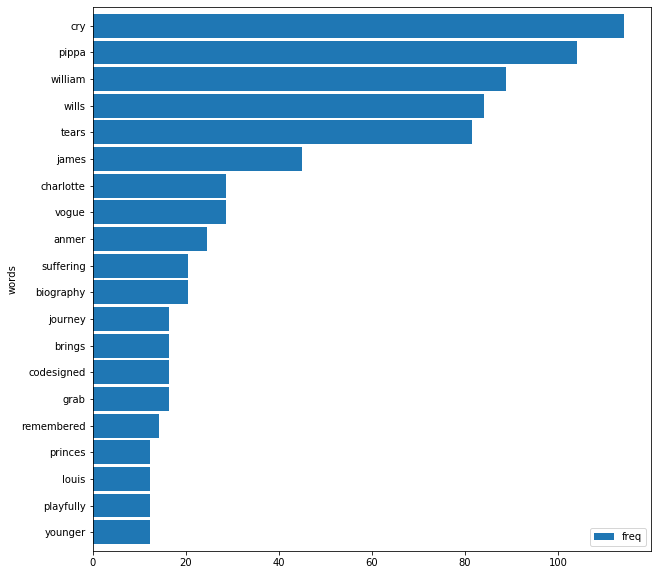

In [127]:
ax = kate_words.plot.barh(x='words', y='freq', width=.9, figsize=(10,10))
ax.invert_yaxis()
plt.savefig("mid_bars.pdf")

## TF-IDF

Term-frequency-inverse document frequency (TF-IDF) will measure the topic of an article by the words it contains. With TF-IDF, words are given weight, measuring relevancey, not frequency. The wordcounts are replaced with TF-IDF scores across the whole dataset.

In [65]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [66]:
# Only include those words that appear in less than 80% of the document and appear in at least 2 documents.
count_vect = CountVectorizer(max_df=0.8, min_df=2)
# Converts a collection of text documents into a matrix of token (word) counts in unicode
doc_term_matrix = count_vect.fit_transform(middleton_all_df['article'].values.astype('U'))

In [67]:
doc_term_matrix

<2348x20567 sparse matrix of type '<class 'numpy.int64'>'
	with 527412 stored elements in Compressed Sparse Row format>

# Topic modeling 

Topic Modeling is an unsupervized machine learning technique to discover the hidden thematic structure in a large corpus of text documents. Latent Dirichlet allocation (LDA) and Non-Negative Matrix Fatactorization (NMF) are the two most popular topic modeling techniques, which I will apply here.

### Using LDA 

Latent Dirichlet Allocation (LDA) is an example of a topic model and is used to classify text in a document to a particular topic. It builds a topic per document model and words per topic model, modeled as Dirichlet distributions.

In [70]:
# I want my text divided into 5 topics. Random_state randomizes the model's train/test data 
LDA = LatentDirichletAllocation(n_components=5, random_state=42)
LDA.fit(doc_term_matrix)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [72]:
first_topic = LDA.components_[0]

In [73]:
# I want the top 10 words associated with each topic 
top_topic_words = first_topic.argsort()[-10:]

In [129]:
# Print the model's results 
for i,topic in enumerate(LDA.components_):
    print(f'Top 10 words for topic #{i}:')
    print([count_vect.get_feature_names()[i] for i in topic.argsort()[-10:]])
#     print('\n')

Top 10 words for topic #0:
['day', 'meghans', 'one', 'also', 'thomas', 'would', 'family', 'markle', 'wedding', 'said']
Top 10 words for topic #1:
['duke', 'one', 'birth', 'sussex', 'first', 'also', 'new', 'duchess', 'baby', 'said']
Top 10 words for topic #2:
['also', 'new', 'wedding', 'first', 'day', 'dress', 'duke', 'couple', 'said', 'duchess']
Top 10 words for topic #3:
['duke', 'visit', 'new', 'archie', 'private', 'sussex', 'one', 'said', 'also', 'duchess']
Top 10 words for topic #4:
['duchess', 'look', 'also', 'wedding', 'black', 'said', 'one', 'siten', 'nvisit', 'dress']


In [75]:
# new_stops = ['siten','said','told','like']
# stop

### Meghan Markle

In [80]:
# Same as above 
count_vect = CountVectorizer(max_df=0.8, min_df=2)
doc_term_matrix = count_vect.fit_transform(markle_all_df['article'].values.astype('U'))

In [81]:
# Same as above 
LDA = LatentDirichletAllocation(n_components=5, random_state=42)
LDA.fit(doc_term_matrix)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [82]:
first_topic = LDA.components_[0]

In [83]:
# Same as above 
top_topic_words = first_topic.argsort()[-10:]

In [84]:
# Same as above 
for i,topic in enumerate(LDA.components_):
    print(f'Top 10 words for topic #{i}:')
    print([count_vect.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['day', 'meghans', 'one', 'also', 'thomas', 'would', 'family', 'markle', 'wedding', 'said']


Top 10 words for topic #1:
['duke', 'one', 'birth', 'sussex', 'first', 'also', 'new', 'duchess', 'baby', 'said']


Top 10 words for topic #2:
['also', 'new', 'wedding', 'first', 'day', 'dress', 'duke', 'couple', 'said', 'duchess']


Top 10 words for topic #3:
['duke', 'visit', 'new', 'archie', 'private', 'sussex', 'one', 'said', 'also', 'duchess']


Top 10 words for topic #4:
['duchess', 'look', 'also', 'wedding', 'black', 'said', 'one', 'siten', 'nvisit', 'dress']




### NME

Another type of topic modeling 

In [137]:
stop = stopwords.words('english')

# Only include those words that appear in less than 80% of the document and appear in at least 2 documents.
tfidf_vect = CountVectorizer(max_df=0.8, min_df=2, stop_words=stop)
# 
doc_term_matrix = tfidf_vect.fit_transform(middleton_all_df['article'].values.astype('U'))

In [138]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=5, random_state=42)
nmf.fit(doc_term_matrix )

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=5, random_state=42, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [139]:
import random

for i in range(10):
    random_id = random.randint(0,len(tfidf_vect.get_feature_names()))
    print(tfidf_vect.get_feature_names()[random_id])

estimating
stride
freeman
unaware
evident
commit
shipped
thatsingingbird
kamilla
razor


In [140]:
first_topic = nmf.components_[0]
top_topic_words = first_topic.argsort()[-10:]

In [141]:
for i,topic in enumerate(nmf.components_):
    print(f'Top 10 words for topic #{i}:')
    print([tfidf_vect.get_feature_names()[i] for i in topic.argsort()[-10:]])
#     print('\n')

Top 10 words for topic #0:
['palace', 'birth', 'princess', 'cambridge', 'charlotte', 'duke', 'george', 'baby', 'william', 'prince']
Top 10 words for topic #1:
['said', 'couple', 'country', 'also', 'first', 'diana', 'khan', 'visit', 'william', 'pakistan']
Top 10 words for topic #2:
['would', 'also', 'markle', 'queen', 'william', 'family', 'said', 'prince', 'harry', 'meghan']
Top 10 words for topic #3:
['pippa', 'prince', 'first', 'day', 'princess', 'nvisit', 'siten', 'wore', 'wedding', 'dress']
Top 10 words for topic #4:
['visit', 'woman', 'told', 'people', 'also', 'children', 'family', 'one', 'time', 'said']


### Meghan Markle 

In [142]:
# Only include those words that appear in less than 80% of the document and appear in at least 2 documents.
tfidf_vect = CountVectorizer(max_df=0.8, min_df=2, stop_words=stop)
# 
doc_term_matrix = tfidf_vect.fit_transform(markle_all_df['article'].values.astype('U'))

In [133]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=5, random_state=42)
nmf.fit(doc_term_matrix )

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=5, random_state=42, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [134]:
import random

for i in range(10):
    random_id = random.randint(0,len(tfidf_vect.get_feature_names()))
    print(tfidf_vect.get_feature_names()[random_id])

accessible
convection
sanstights
inaccurate
ladiesinwaiting
hotels
valentinos
lessons
cuddles
theresa


In [135]:
first_topic = nmf.components_[0]
top_topic_words = first_topic.argsort()[-10:]

In [136]:
for i,topic in enumerate(nmf.components_):
    print(f'Top 10 words for topic #{i}:')
    print([tfidf_vect.get_feature_names()[i] for i in topic.argsort()[-10:]])
#     print('\n')

Top 10 words for topic #0:
['like', 'really', 'time', 'us', 'family', 'think', 'would', 'know', 'said', 'markle']
Top 10 words for topic #1:
['visit', 'october', 'australia', 'first', 'baby', 'sydney', 'couple', 'said', 'duke', 'duchess']
Top 10 words for topic #2:
['also', 'st', 'queen', 'castle', 'markle', 'said', 'chapel', 'day', 'windsor', 'wedding']
Top 10 words for topic #3:
['sussex', 'dress', 'first', 'said', 'baby', 'meghans', 'new', 'also', 'one', 'duchess']
Top 10 words for topic #4:
['police', 'white', 'time', 'man', 'woman', 'troops', 'afghanistan', 'trump', 'black', 'visit']
